In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!7z x /content/drive/MyDrive/Claheclasses_1.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 268015777 bytes (256 MiB)

Extracting archive: /content/drive/MyDrive/Claheclasses_1.zip
 39% 4096 Open              --
Path = /content/drive/MyDrive/Claheclasses_1.zip
Type = zip
Physical Size = 268015777

  0%      3% 405 - Claheclasses_1/1/40259_left.jpeg                                             6% 723 - Claheclasses_1/1/17453_left.jpeg                                             9% 1055 - Claheclasses_1/1/37332

In [3]:
# import the libraries
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout

import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pathlib
data_dir = '/content/Claheclasses_1'
data_dir = pathlib.Path(data_dir)

In [5]:
image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)

10304


In [6]:
batch_size = 16
img_height = 299
img_width = 299

In [7]:
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    shuffle = True,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 10304 files belonging to 2 classes.


In [8]:
class_names = dataset.class_names
print(class_names)

['0', '1']


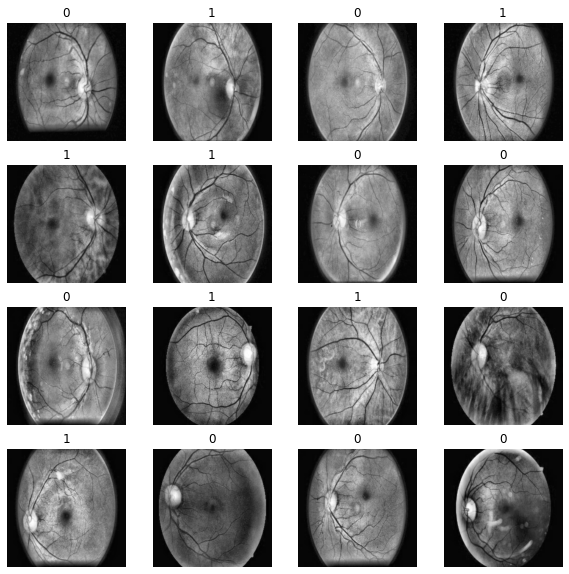

In [ ]:
plt.figure(figsize=(10, 10))
for images_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 7213 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 10304 files belonging to 2 classes.
Using 3091 files for validation.


In [11]:
num_classes = len(class_names)

In [12]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model

In [13]:
base_res = model = ResNet50(weights='imagenet', include_top=False)
base_res.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                          

In [14]:
base_res.trainable = False

In [15]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_res(image_batch)
print(feature_batch.shape)

(16, 10, 10, 2048)


In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [17]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 2)


In [18]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = base_res(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.05)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
import time
start_cnn = time.time()

In [20]:
model.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

path = 'best_model_res.hdf5'
checkpoint = ModelCheckpoint(path, monitor='val_accuracy', verbose = 1, save_best_only = True, mode='max')
es = EarlyStopping(monitor='val_accuracy', patience=7)

callback_list = [checkpoint,es]

In [29]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs, 
  callbacks=callback_list  
)

Epoch 1/50
451/451 [==============================] - ETA: 0s - loss: 0.6047 - accuracy: 0.6710
Epoch 1: val_accuracy improved from -inf to 0.60207, saving model to best_model_res.hdf5
451/451 [==============================] - 63s 139ms/step - loss: 0.6047 - accuracy: 0.6710 - val_loss: 0.6890 - val_accuracy: 0.6021
Epoch 2/50
451/451 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.6811
Epoch 2: val_accuracy did not improve from 0.60207
451/451 [==============================] - 63s 138ms/step - loss: 0.6003 - accuracy: 0.6811 - val_loss: 0.8764 - val_accuracy: 0.5746
Epoch 3/50
451/451 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.6791
Epoch 3: val_accuracy improved from 0.60207 to 0.62245, saving model to best_model_res.hdf5
451/451 [==============================] - 63s 139ms/step - loss: 0.6061 - accuracy: 0.6791 - val_loss: 0.6606 - val_accuracy: 0.6225
Epoch 4/50
451/451 [==============================] - ETA: 0s - loss: 0.5963 -

In [30]:
scores = model.evaluate(val_ds)

194/194 [==============================] - 19s 97ms/step - loss: 0.6712 - accuracy: 0.6325


In [31]:
scores = model.evaluate(train_ds)

451/451 [==============================] - 44s 98ms/step - loss: 0.5289 - accuracy: 0.7317


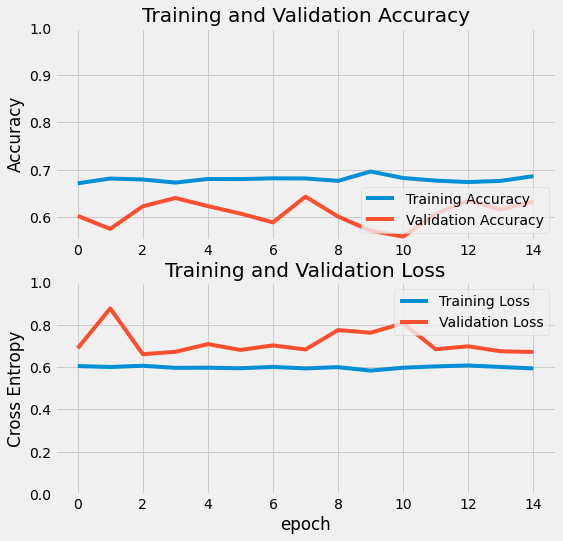

In [32]:
plt.style.use('fivethirtyeight')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 23ms/step


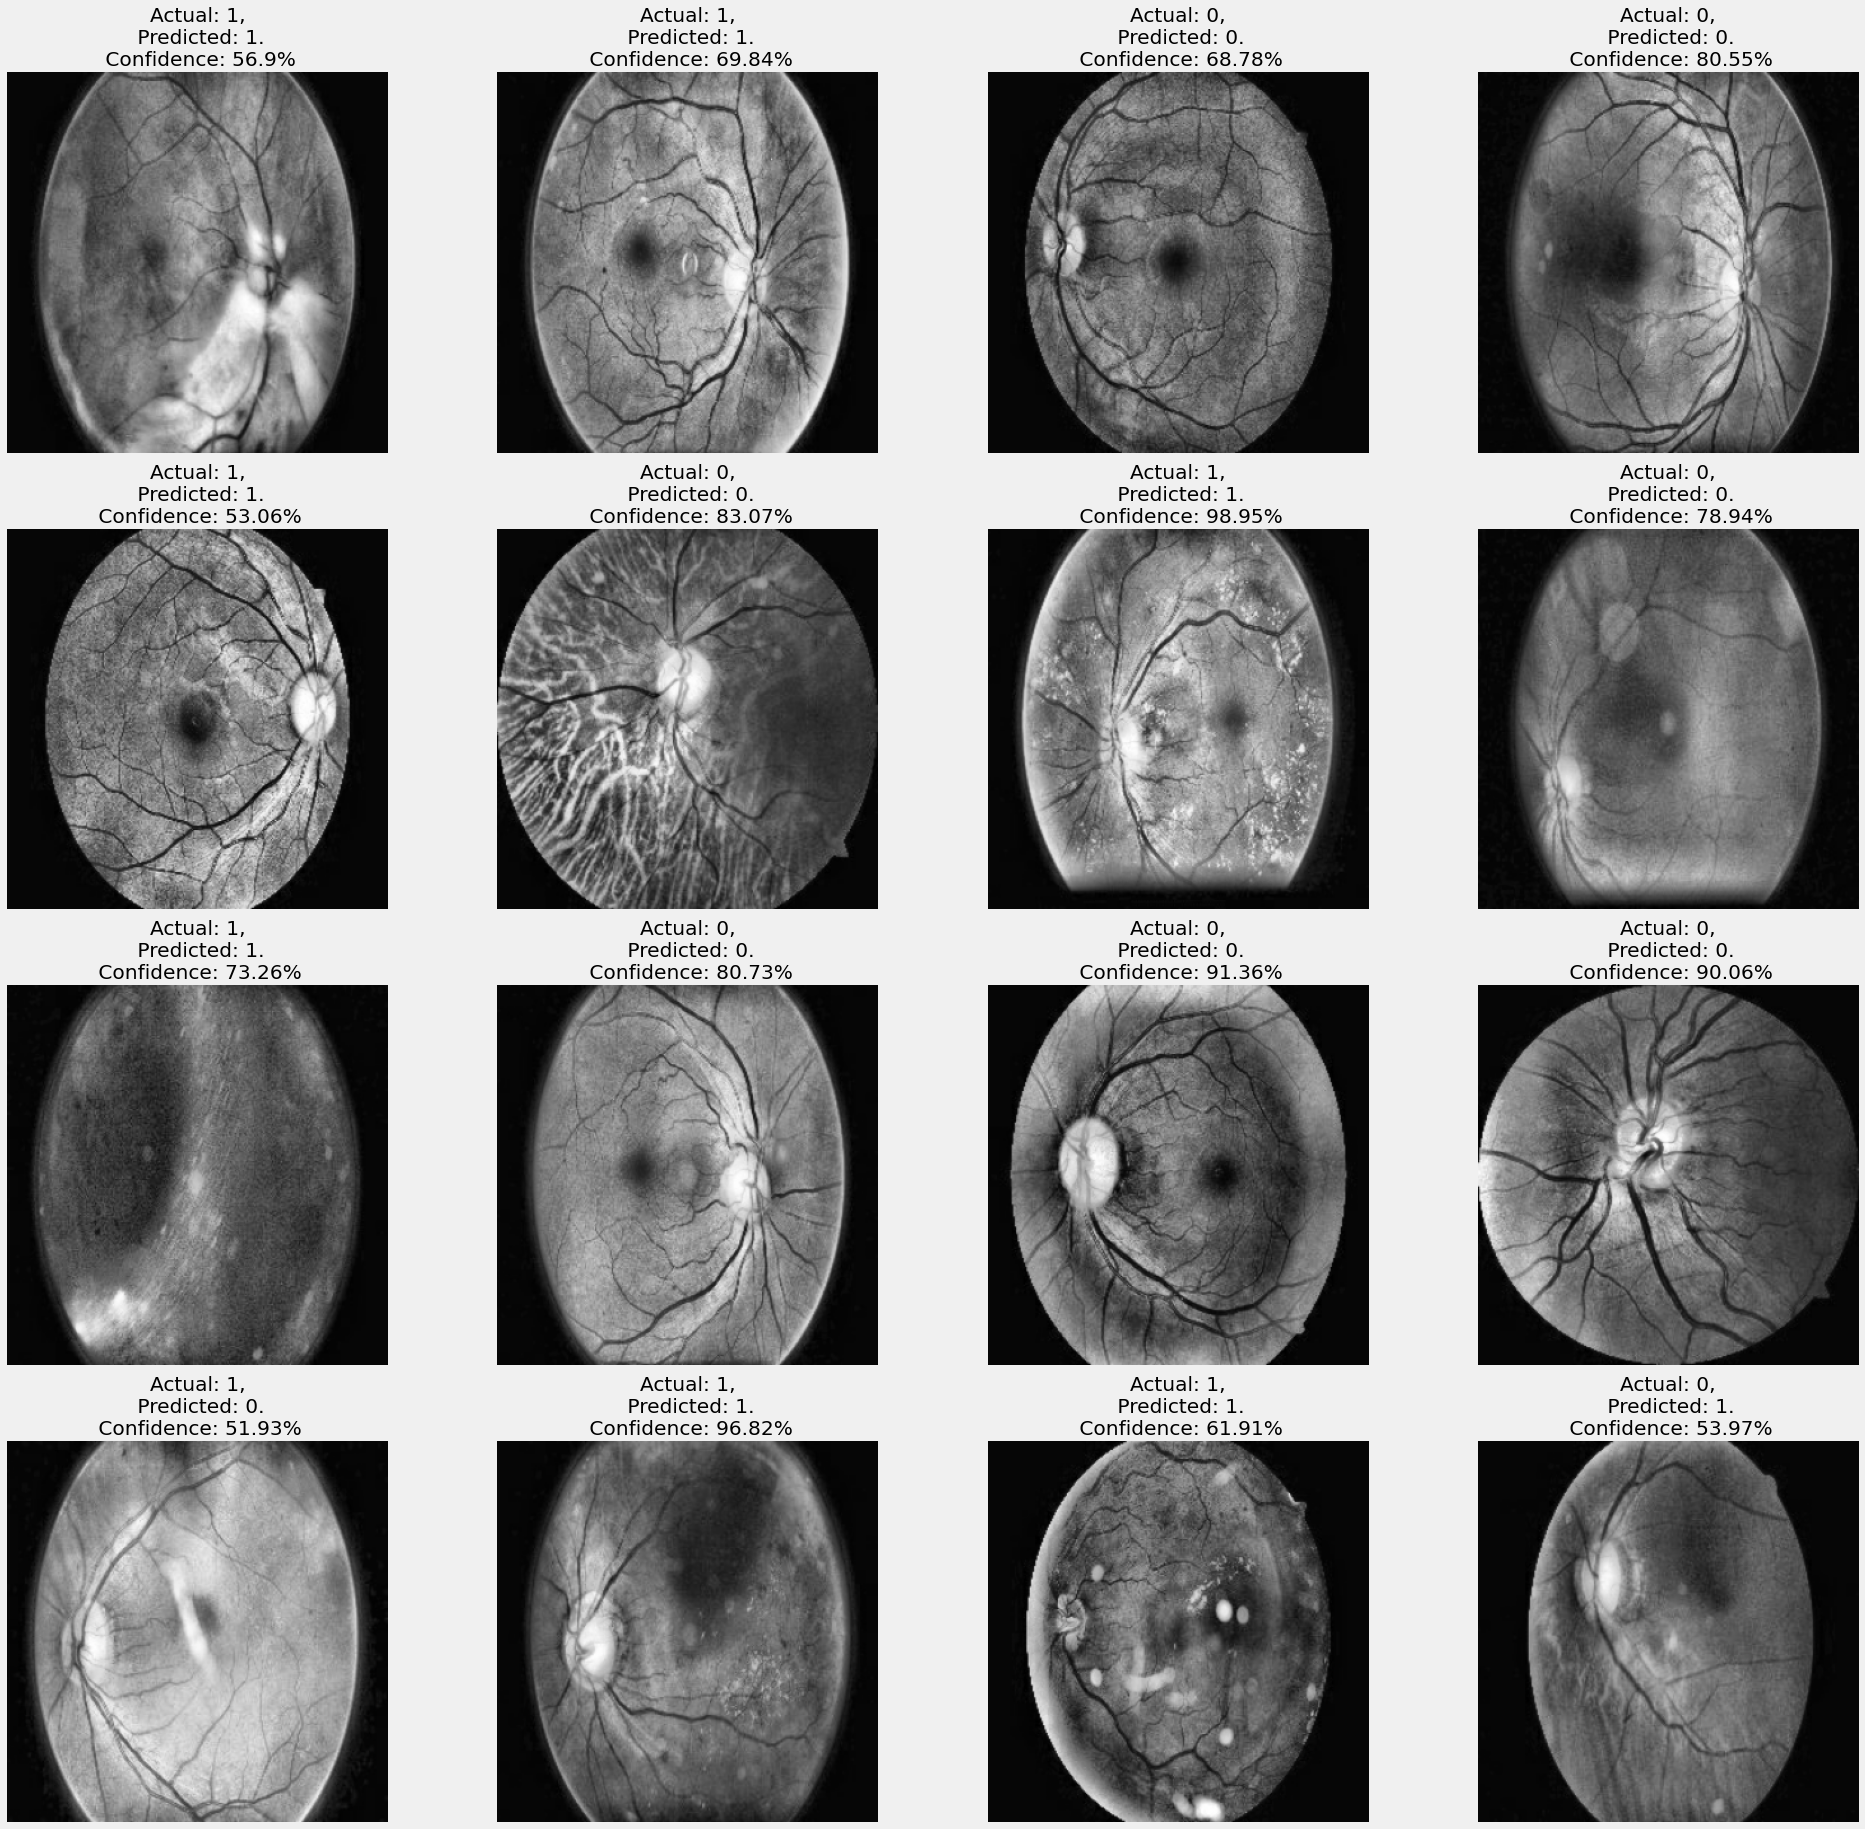

In [34]:
plt.figure(figsize=(30, 30))
for images, labels in val_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [35]:
X = []
y = []
for image,labels in val_ds.take(96):
    for i in image:
        img = i.numpy()
        X.append(img)
    lbl_list = labels.numpy()    
    y.extend(lbl_list)  

In [36]:
x = np.array(X)

In [37]:
y = np.array(y)

In [38]:
x.shape

(1536, 299, 299, 3)

In [39]:
x.shape, y.shape

((1536, 299, 299, 3), (1536,))

In [ ]:
model.evaluate(x[:1536],y[:1536])

48/48 [==============================] - 11s 205ms/step - loss: 0.6897 - accuracy: 0.6270


[0.6897144913673401, 0.626953125]

In [40]:
from sklearn.metrics import confusion_matrix , classification_report
import numpy as np
y_pred = model.predict(x[:1536])
y_pred_classes = [np.argmax(element) for element in y_pred]
 
print("Classification Report: \n", classification_report(y[:1536], y_pred_classes))

48/48 [==============================] - 9s 166ms/step
Classification Report: 
               precision    recall  f1-score   support

           0       0.61      0.70      0.65       762
           1       0.65      0.55      0.60       774

    accuracy                           0.62      1536
   macro avg       0.63      0.63      0.62      1536
weighted avg       0.63      0.62      0.62      1536



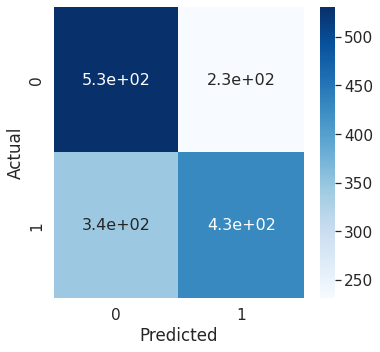

In [42]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import pandas as pd
target_names = class_names

cm1 = confusion_matrix(y[:1536], y_pred_classes)
cm_df1 = pd.DataFrame(cm1,
                     index = ['0', '1'], 
                     columns = ['0', '1',])
cm_df1.index.name = 'Actual'
cm_df1.columns.name = 'Predicted'
plt.figure(figsize = (5,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df1, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [45]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


48/48 [==============================] - 8s 168ms/step


<Figure size 2520x2520 with 0 Axes>

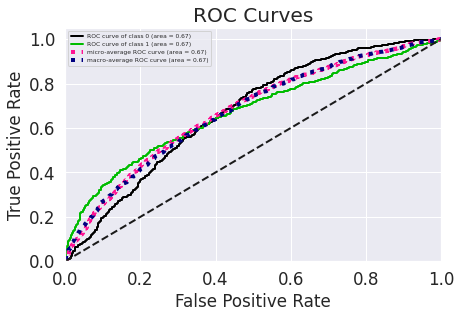

In [52]:
import scikitplot as skplt
import matplotlib.pyplot as plt

plt.figure(figsize=(35, 35))
y_true = y[:1536]
y_probas = model.predict(x[:1536])
skplt.metrics.plot_roc_curve(y_true, y_probas)
plt.legend(loc=2, prop={'size': 6})
plt.show()